Imports

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers, models

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest

1. Load the dataset: The dataset will contain a single column temperature and a date column.


In [8]:
df = pd.read_csv("/content/drive/MyDrive/NNDL_LAB/weather_data.csv")
df.head()

,date,temperature
0,2014-01-01,10.248357
1,2014-01-02,9.950428
2,2014-01-03,10.362958
3,2014-01-04,10.820167
4,2014-01-05,9.961091


In [9]:
# Sorting the values based on ascending value of date
data = df.sort_values('date')
data.set_index('date', inplace=True)
data.head()

,temperature
date,
2014-01-01,10.248357
2014-01-02,9.950428
2014-01-03,10.362958
2014-01-04,10.820167
2014-01-05,9.961091


2. Preprocess the data: Normalize the temperature data and split it into training and testing
sets.


In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['temperature']])
scaled_data[:5]

timesteps = 60
data_X = []
data_Y = []

for i in range(len(scaled_data) - timesteps - 1):
    _x, _y = scaled_data[i:(i + timesteps)], scaled_data[i + timesteps]
    data_X.append(_x)
    data_Y.append(_y)

data_X, data_Y = np.array(data_X), np.array(data_Y)

train_size  = int(len(data_X) * 0.8)
test_size = len(data_X) - train_size
train_X, train_Y, test_X, test_Y = data_X[0:train_size], data_Y[0:train_size], data_X[train_size:len(data_X)], data_Y[train_size:len(data_X)]


3. Build an LSTM Autoencoder:
 - The encoder should reduce the input dimensions to a latent representation.
 - The decoder should reconstruct the input from the latent representation.


In [11]:
# LSTM layers --> reduce the input dimensions to a latent representation.
encoder_inputs = keras.Input(shape=(timesteps, 1))
x = layers.LSTM(64, return_sequences=True)(encoder_inputs)
x = layers.LSTM(32, return_sequences=False)(x)
encoder_outputs = x
encoder = keras.Model(encoder_inputs, encoder_outputs, name="encoder")
encoder.summary()

# LSTM layers --> reconstruct the input from the latent representation.
decoder_inputs = keras.Input(shape=(32,))
x = layers.RepeatVector(timesteps)(decoder_inputs)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=True)(x)
decoder_outputs = layers.TimeDistributed(layers.Dense(1))(x)
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()

# LSTM Autoencoder
autoencoder = keras.Sequential([encoder, decoder])
autoencoder.compile(optimizer="adam", loss="mse")

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 60, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 60, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,312 (114.50 KB)

 Trainable params: 29,312 (114.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 60, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 60, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 60, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 60, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,217 (129.75 KB)

 Trainable params: 33,217 (129.75 KB)

 Non-trainable params: 0 (0.00 B)

4. Train the model: Train the autoencoder on the training data and evaluate the
reconstruction error on the test set.


In [12]:
history = autoencoder.fit(train_X, train_X, epochs=50, batch_size=32, validation_data=(test_X, test_X))

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - loss: 0.0825 - val_loss: 0.0112
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - loss: 0.0098 - val_loss: 0.0060
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - loss: 0.0052 - val_loss: 0.0032
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 150

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step


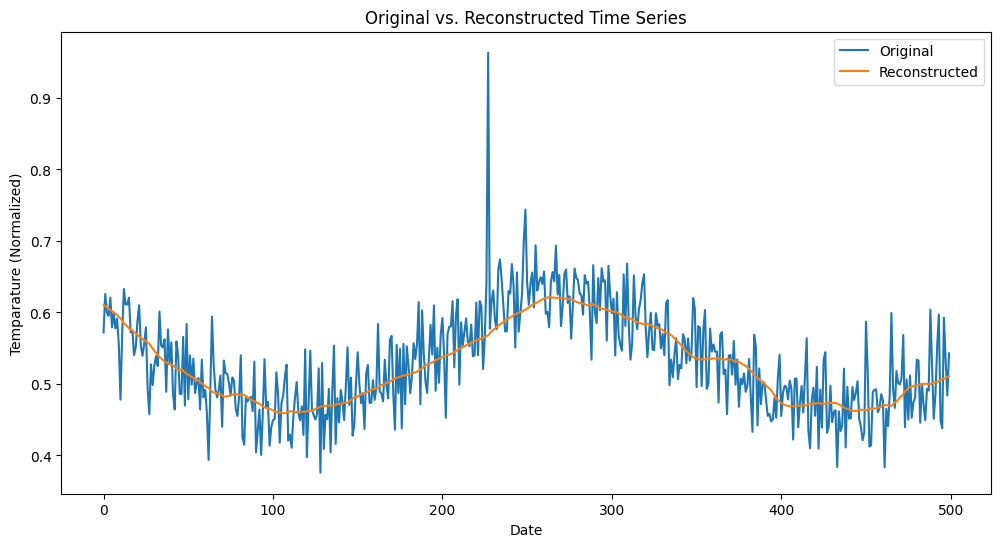

In [13]:
predictions = autoencoder.predict(test_X)
# Plot original vs reconstructed sequences
plt.figure(figsize=(12, 6))
plt.plot(test_Y, label='Original')
plt.plot(predictions[:, -1, 0], label='Reconstructed')
plt.legend()
plt.title('Original vs. Reconstructed Time Series')
plt.xlabel('Date')
plt.ylabel('Temparature (Normalized)')
plt.show()

5. Anomaly Detection: Use the reconstruction error to detect anomalies. Define a threshold
for the reconstruction error, and identify days where the temperature is considered
anomalous.


Reconstruction Loss (MSE): 0.002524015260860324


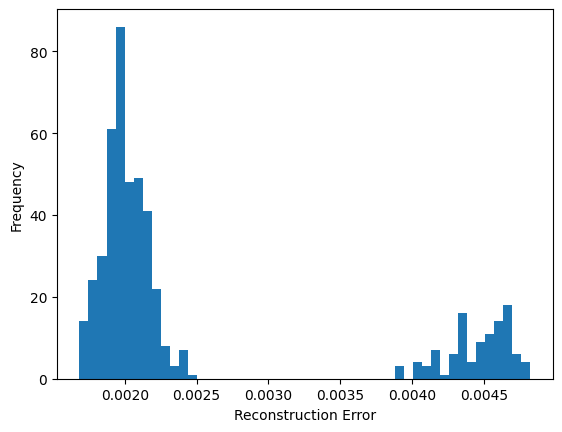

In [14]:
# Calculate the reconstruction loss using MSE.
reconstruction_loss = autoencoder.evaluate(test_X, test_X, verbose=0)
print("Reconstruction Loss (MSE):", reconstruction_loss)

mse = np.mean(np.power(test_X - predictions, 2), axis=1)
plt.hist(mse, bins=50)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

In [21]:
# Invert scaling to get original temperature values, calculate MSE (reconstruction error) and threshold
original_temp = scaler.inverse_transform(data_Y[train_size:])
mse = np.mean(np.power(test_X - predictions, 2), axis=1)
threshold = np.mean(mse) + 2 * np.std(mse)

#indices of the anomalous data points
anomalies = np.where(mse > threshold)[0]

6. Visualize the results: Plot the original temperature data and highlight the detected
anomalies.

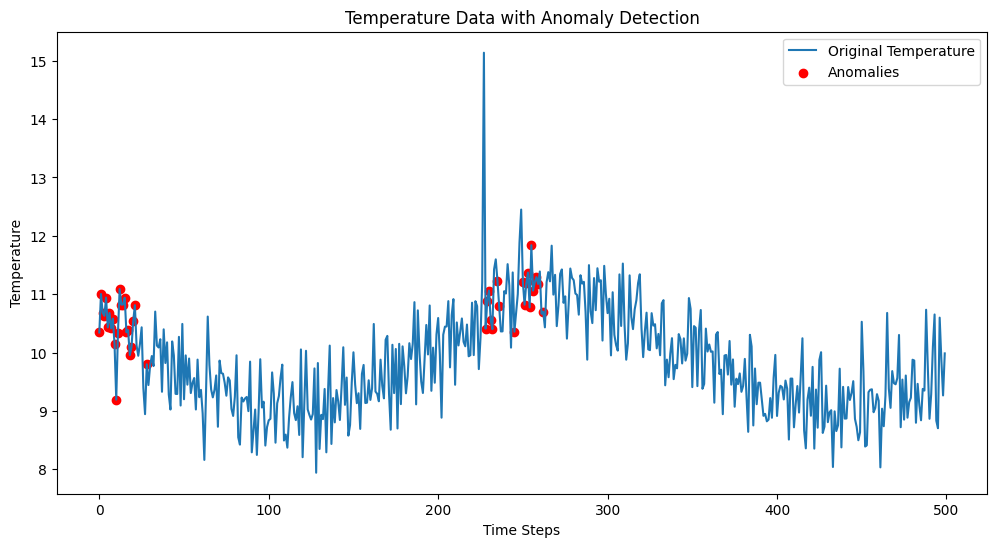

In [22]:
# Plot the original temperature data with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.plot(original_temp, label='Original Temperature')
plt.scatter(anomalies, original_temp[anomalies], color='red', label='Anomalies')  # Highlight anomalies with red cocor
plt.legend()
plt.title('Temperature Data with Anomaly Detection')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.show()

Insights:
- Using LSTM autoencoders, we tried to predict the weather for a time series.
- Took the timestep of 60 records and passed it to the autoencoder to predict.
- Autoencoder contained 2 levels of LSTM for both encoder and decoder.
- The MSE/ reconstruction error and anomoly graphs are generated to understand how far the predicted data is from the actual data.
- We obtained a small MSE of 0.002524015260860324, symbolizes that the predicted output was similar to the actual output.